**Load Tools and Configs**

In [1]:
import os
import sys

# 获取项目根目录
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# 添加 src 目录到 sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from utils.load_notebook_config import LoadConfig
from tools.tools_lookup_policy import lookup_policy
from tools.tools_flights import fetch_user_flight_information, search_flights, update_ticket_to_new_flight, cancel_ticket
from tools.tools_hotels import search_hotels, book_hotel, update_hotel, cancel_hotel
from tools.tools_excursions import search_trip_recommendations, book_excursion, update_excursion, cancel_excursion
from tools.tools_car_rental import search_car_rentals, book_car_rental, update_car_rental, cancel_car_rental
from utils.utilities import create_tool_node_with_fallback, _print_event

CFG = LoadConfig()

import os
from dotenv import load_dotenv
import yaml
from pyprojroot import here
from langchain_openai import ChatOpenAI
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_API_BASE'] = os.getenv("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
OPENAI_API_BASE= os.environ.get("OPENAI_API_BASE")


**Load the LLM**

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_base=OPENAI_API_BASE,
    openai_api_key=OPENAI_API_KEY,
    # tream=True,
    model="gpt-4o-mini",
    temperature=0)


**Define the State**

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str

**Define the Assistant:** This class takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [4]:
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

**Define the Primary Agent's System Role**

In [5]:
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

**Wrap Up the Tools and Bind Them to the Primary Agent (LLM)**

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

**Define the Graph**

Now, create the graph, incorporating two adjustments from Part 1 to address our earlier concerns:

1. Insert an interrupt before utilizing a tool.
2. Populate the user state explicitly within the first node, ensuring the assistant doesn't need to use a tool solely to gather information about the user.

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

**Plot the Graph**

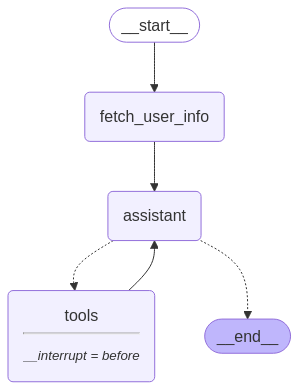

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Sample Questions**

In [9]:
# Let's create an example conversation a user might have with the assistant
sample_questions = [
    # "Hi there, what time is my flight?",
    # "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

**Prepare the Databases and Configure Settings for a Sample User**

In [10]:
from utils.utilities import update_dates
import uuid

# Update with the backup file so we can restart from the original place in each section
# db = update_dates(CFG.local_file, CFG.backup_file)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

**Test the Bot**

In [17]:
from langchain_core.messages import ToolMessage


_printed = set()
for question in sample_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = graph.get_state(config)

================================ Human Message =================================

Update my flight to sometime next week then
================================== Ai Message ==================================
Tool Calls:
  search_flights (chatcmpl-SmCgcMaov6yKaJQMOjE93QyUhsjOX)
 Call ID: chatcmpl-SmCgcMaov6yKaJQMOjE93QyUhsjOX
  Args:
    departure_airport: CDG
    arrival_airport: BSL
    start_time: 2025-03-17T00:00:00
    end_time: 2025-03-24T23:59:59
    limit: 10


In [18]:
snapshot[0]["messages"][-1].content

'I am currently unable to find any available flights from CDG to BSL for next week. This could be due to limited flight availability or scheduling changes.\n\nWould you like me to check flights for a different route, or perhaps adjust the dates further? Please let me know how you would like to proceed!'

------------------------------------------------
## **Performance**

Now our assistant was able to save a step to respond with our flight details. We also completely controlled which actions were performed. This all worked using LangGraph's interrupts and checkpointers.

## **Problems**
We are involving the user in EVERY assistant action which is not necessary.

------------------------------------------------